In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
#user engagement data
user_eng = pd.read_csv('takehome_user_engagement.csv')
#date time
user_eng['time_stamp'] = pd.to_datetime(user_eng['time_stamp'])

In [3]:
user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [5]:
start_active = pd.DataFrame(user_eng.groupby('user_id')['time_stamp'].min()).reset_index().rename(columns={'time_stamp':'start_active'})

In [6]:
# change index as time stamp
user_eng.set_index('time_stamp',inplace=True)

In [7]:
# create adopted user variable
adopted_user = pd.DataFrame(user_eng.groupby('user_id')['visited'].rolling(window='7D').sum())

adopted_user = pd.DataFrame(adopted_user.groupby('user_id')['visited'].max())

#take the cut off visited >=3 
adopted_user['adopted_user'] = adopted_user.visited>=3

#replace False with 0 and True with 1 
adopted_user.replace({False:0,True:1},inplace=True)
adopted_user = adopted_user.reset_index()

In [8]:
adopted_user = adopted_user.merge(start_active,on='user_id')
adopted_user.head()

,user_id,visited,adopted_user,start_active
0,1,1.0,0,2014-04-22 03:53:30
1,2,3.0,1,2013-11-15 03:45:04
2,3,1.0,0,2013-03-19 23:14:52
3,4,1.0,0,2013-05-22 08:09:28
4,5,1.0,0,2013-01-22 10:14:20


In [9]:
users = pd.read_csv('takehome_users.csv',encoding='iso8859_15')

users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [10]:
users.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [11]:
users.shape

(12000, 10)

In [12]:
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [13]:
users.rename(columns={'object_id':'user_id'},inplace=True)

In [14]:
df = users.merge(adopted_user, on='user_id', how='left')

In [15]:
df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopted_user,start_active
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,0.0,2014-04-22 03:53:30
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,3.0,1.0,2013-11-15 03:45:04
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1.0,0.0,2013-03-19 23:14:52
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1.0,0.0,2013-05-22 08:09:28
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1.0,0.0,2013-01-22 10:14:20


In [16]:
# Users that are invited by other users
df['is_invited'] = df.invited_by_user_id.notnull().astype('int')

In [17]:
# time difference between starting to being active and creation time
df['time_diff'] = (df['start_active'] - df['creation_time'])

In [18]:
# convert time difference to hours
df['time_diff'] = df['time_diff']/np.timedelta64(1,'h')

In [19]:
# Create y variable adopted user
#group the data by 'user_id' and add rolling sum within 7 days on the 'visited' column
df['visited'] = df.visited.notnull().astype('int')

In [21]:
df.drop(['user_id','creation_time','name','email','last_session_creation_time','invited_by_user_id','org_id','visited','start_active'],inplace=True,axis=1)

In [22]:
df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,is_invited,time_diff
0,GUEST_INVITE,1,0,0.0,1,0.0
1,ORG_INVITE,0,0,1.0,1,0.0
2,ORG_INVITE,0,0,0.0,1,0.0
3,GUEST_INVITE,0,0,0.0,1,24.0
4,GUEST_INVITE,0,0,0.0,1,120.0


In [23]:
df.isna().sum()

creation_source                  0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
adopted_user                  3177
is_invited                       0
time_diff                     3177
dtype: int64

In [24]:
df.dropna(inplace=True)

In [25]:
df.isna().sum()

creation_source               0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
adopted_user                  0
is_invited                    0
time_diff                     0
dtype: int64

In [26]:
df.shape

(8823, 6)

In [27]:
df = pd.get_dummies(df)

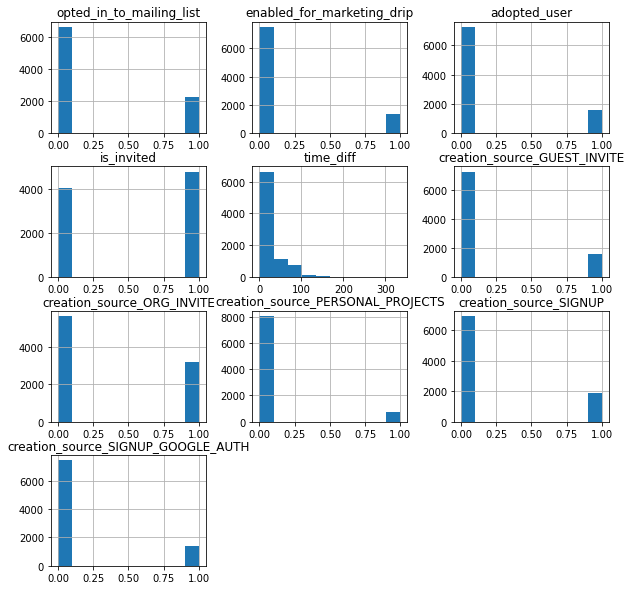

In [30]:
# histograms
df.hist(figsize=(10,10))
plt.show()

In [28]:
X = df.drop(['adopted_user'],axis=1)
y = df.adopted_user


In [31]:
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [33]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)
print('RF')
print(cm)

RF
[[2389   10]
 [ 510    3]]


In [34]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [35]:
norm = MinMaxScaler()
norm.fit(X_train)
norm.transform(X_train)
norm.transform(X_test)

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [36]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_predict_test = rf.predict(X_test)
y_predict_train = rf.predict(X_train)

In [37]:
print(accuracy_score(y_test,y_predict_test))

0.8210851648351648


In [38]:
print(accuracy_score(y_train,y_predict_train))

0.8167822703434275
